In [30]:
import numpy as np
import matplotlib.pyplot as plt 
import h5py
from mayavi import mlab
# import pyvista as pv
# mlab.init_notebook()

from mpl_toolkits.mplot3d import Axes3D

In [37]:
filename = "data/lcdm_snap000_B.h5"

h5_file = h5py.File(filename, "r")

dataset = h5_file["data"]

data = dataset[()]

print(np.shape(data))


(64, 64, 64, 3)


In [45]:
# print(data[:,:,:,0].min())

-1.964049398878732e-08


In [32]:
# x, y = np.mgrid[-3:3:100j, -3:3:100j]
# z = np.sin(x*y)

# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection="3d")

# # ax.plot_surface(x,y,z, cmap="viridis")

# ax.plot_trisurf(x.flatten(), y.flatten(), z.flatten(), cmap="viridis")

# plt.show()

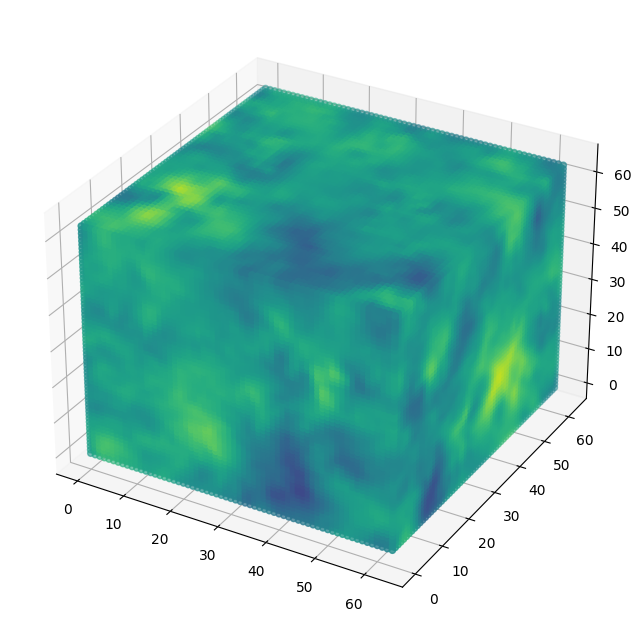

In [41]:
# mlab.contour3d(data, colormap="viridis")
# mlab.show()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")

x, y, z, = np.meshgrid(range(64), range(64), range(64))

ax.scatter(x.flatten(), y.flatten(), z.flatten(), c=data[:,:,:,0].flatten(), cmap="viridis")